Data obtained from project "abstract"
```python
epochs[-1].get_data().shape # The Epochs object of the last subject in numpy array

e = epochs[-1][["img","sf","toon"]]

X = e.get_data()[:,:28,:]
Y = get_labels_from_events(e.events, e.event_id)

X.shape

assert X.shape[0] == Y.shape[0]

with open("subj28.pkl", "wb") as f:
    pickle.dump(epochs[-1], f, protocol=pickle.HIGHEST_PROTOCOL)
```



.File "subj28.pkl" is a pickled tuple of two numpy arrays: X and Y. X has shape (797 epochs, 28 channels, 501 samples) and Y has shape (797, 4). It is three experimental categories and five affective classes one-hot-encoded into 4 dimensions. 

```python
    m = {"0": np.array([ 0, 0]),
        "1": np.array([ 1, 1]),
        "2": np.array([-1, 1]),
        "3": np.array([-1,-1]),
        "4": np.array([ 1,-1])}
    c = {"img": np.array([0, 0]),
        "sf":   np.array([1, 0]),
        "toon": np.array([0, 1])}
```

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import torch
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score

In [2]:
#!pip install torchmetrics
import torchmetrics
accuracy = torchmetrics.Accuracy()

In [3]:
with open("ex/subj28.pkl", 'rb') as f:
    X,Y = pickle.load(f)
print(X.shape)
print(Y.shape)

(797, 28, 501)
(797, 4)


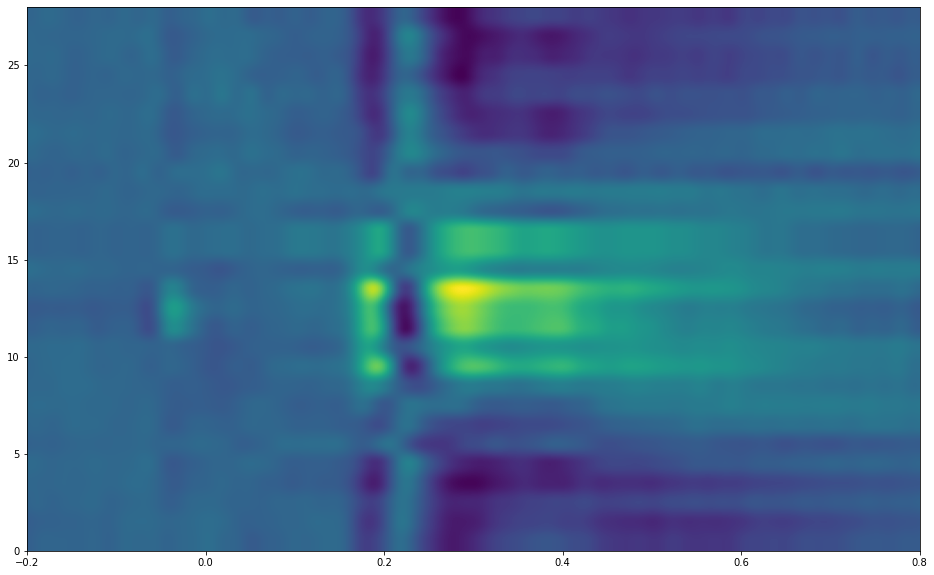

In [4]:
fs = 500
tmin = -0.200
tmax = 0.800
ch_names = ['Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'Cz', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'Pz', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']
t = np.linspace(tmin, tmax, X.shape[2])
fig, ax = plt.subplots(figsize=(16,10))
ax.imshow(X.mean(axis=0), extent=[tmin, tmax,0,28], interpolation=None)
ax.set_aspect("auto")
plt.show()

Simplest attempt, every sample in every channel is a variable observed on every trial.

In [5]:
n_channels = X.shape[1]
n_samples = X.shape[2]
X = X.reshape(797,-1)
print(X.shape)

(797, 14028)


In [6]:
Y = Y[:,:2].astype("int")
print(Y.shape)

(797, 2)


(797, 14028)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


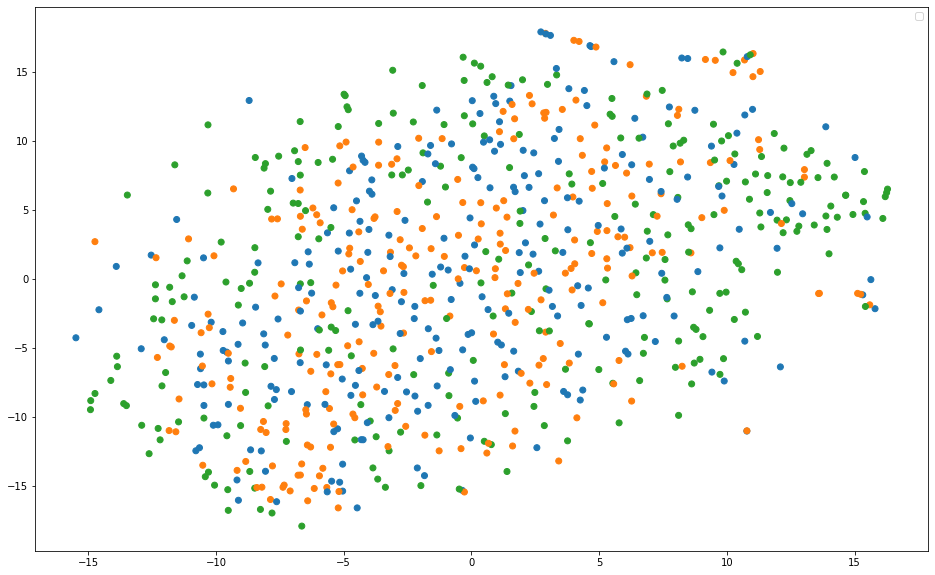

In [7]:
print(X.shape)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
fig = plt.figure(figsize=(16,10))
cmap = plt.cm.get_cmap('tab10')
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cmap([a*2 + b for a,b in Y[:,:2]]))
plt.legend()

The features don't seem to be linearly separable, so a high accuracy is not expected.

A 70/30 split is done for testing and training purposes. This evaluates the model's generalizability.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

## The linear model

In [9]:
from torch.autograd import Variable


class LogisticRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out
   
    def init(self, init_func, *params, **kwargs):
        for p in self.parameters():
            init_func(p, *params, **kwargs)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [11]:
inputDim = X.shape[1] 
outputDim = Y.shape[1]
learningRate = 0.1 
epochs = 500
model = LogisticRegression(inputDim, outputDim)
model.to(device)

LogisticRegression(
  (linear): Linear(in_features=14028, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [12]:
criterion = torch.nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
accuracy.to(device)

ltr_curve = []
atr_curve  = []
lts_curve = []
ats_curve  = []
model.init(torch.nn.init.uniform_)
for epoch in range(epochs):
    # Train Set
    inputs = Variable(torch.tensor(X_train.astype(np.float32))).to(device)
    labels = Variable(torch.tensor(y_train.astype(np.float32))).to(device)

    optimizer.zero_grad()
    y_hat = model(inputs)

    loss = criterion(y_hat, labels)
    train_loss = loss.item()
    ltr_curve.append(train_loss)
    
    train_acc = accuracy(y_hat, labels.int())
    atr_curve.append(train_acc.cpu().detach().numpy())
    
    # Optimization
    loss.backward()
    optimizer.step()
    
    # Test set    
    y_hat = model(Variable(torch.tensor(X_test.astype(np.float32))).to(device))
    test_lbls = Variable(torch.tensor(y_test.astype(np.float32))).to(device)
    test_loss = criterion(y_hat, test_lbls)
    test_loss = test_loss.item()
    lts_curve.append(test_loss)
    test_acc = accuracy(y_hat, test_lbls.int())
    ats_curve.append(test_acc.cpu().detach().numpy())


    print(f"epoch {epoch}, loss {loss.item()}, Acctst: {ats_curve[-1]}")

epoch 0, loss 0.8140432238578796, Acctst: 0.3375000059604645
epoch 1, loss 0.8097411394119263, Acctst: 0.3375000059604645
epoch 2, loss 0.8055392503738403, Acctst: 0.3375000059604645
epoch 3, loss 0.8014355897903442, Acctst: 0.3375000059604645
epoch 4, loss 0.7974281907081604, Acctst: 0.3375000059604645
epoch 5, loss 0.7935150265693665, Acctst: 0.3375000059604645
epoch 6, loss 0.7896943092346191, Acctst: 0.3375000059604645
epoch 7, loss 0.7859640121459961, Acctst: 0.3375000059604645
epoch 8, loss 0.7823222279548645, Acctst: 0.3375000059604645
epoch 9, loss 0.7787672281265259, Acctst: 0.3375000059604645
epoch 10, loss 0.7752971649169922, Acctst: 0.3375000059604645
epoch 11, loss 0.7719101309776306, Acctst: 0.3375000059604645
epoch 12, loss 0.7686043977737427, Acctst: 0.3375000059604645
epoch 13, loss 0.7653781175613403, Acctst: 0.3375000059604645
epoch 14, loss 0.7622296810150146, Acctst: 0.3375000059604645
epoch 15, loss 0.7591572403907776, Acctst: 0.3375000059604645
epoch 16, loss 0.7

epoch 140, loss 0.6427444219589233, Acctst: 0.6625000238418579
epoch 141, loss 0.6426071524620056, Acctst: 0.6625000238418579
epoch 142, loss 0.6424732208251953, Acctst: 0.6625000238418579
epoch 143, loss 0.6423423886299133, Acctst: 0.6625000238418579
epoch 144, loss 0.6422145962715149, Acctst: 0.6625000238418579
epoch 145, loss 0.64208984375, Acctst: 0.6625000238418579
epoch 146, loss 0.6419680118560791, Acctst: 0.6625000238418579
epoch 147, loss 0.6418491005897522, Acctst: 0.6625000238418579
epoch 148, loss 0.641732931137085, Acctst: 0.6625000238418579
epoch 149, loss 0.6416195034980774, Acctst: 0.6625000238418579
epoch 150, loss 0.6415086984634399, Acctst: 0.6625000238418579
epoch 151, loss 0.6414005160331726, Acctst: 0.6625000238418579
epoch 152, loss 0.6412948966026306, Acctst: 0.6625000238418579
epoch 153, loss 0.6411916613578796, Acctst: 0.6625000238418579
epoch 154, loss 0.6410908102989197, Acctst: 0.6625000238418579
epoch 155, loss 0.6409924030303955, Acctst: 0.662500023841857

epoch 273, loss 0.637089729309082, Acctst: 0.6625000238418579
epoch 274, loss 0.6370834708213806, Acctst: 0.6625000238418579
epoch 275, loss 0.6370773315429688, Acctst: 0.6625000238418579
epoch 276, loss 0.6370712518692017, Acctst: 0.6625000238418579
epoch 277, loss 0.6370653510093689, Acctst: 0.6625000238418579
epoch 278, loss 0.6370596885681152, Acctst: 0.6625000238418579
epoch 279, loss 0.6370540261268616, Acctst: 0.6625000238418579
epoch 280, loss 0.6370484828948975, Acctst: 0.6625000238418579
epoch 281, loss 0.6370431184768677, Acctst: 0.6625000238418579
epoch 282, loss 0.6370378732681274, Acctst: 0.6625000238418579
epoch 283, loss 0.637032687664032, Acctst: 0.6625000238418579
epoch 284, loss 0.6370277404785156, Acctst: 0.6625000238418579
epoch 285, loss 0.6370227932929993, Acctst: 0.6625000238418579
epoch 286, loss 0.6370179653167725, Acctst: 0.6625000238418579
epoch 287, loss 0.6370132565498352, Acctst: 0.6625000238418579
epoch 288, loss 0.6370087265968323, Acctst: 0.66250002384

epoch 406, loss 0.6368217468261719, Acctst: 0.6625000238418579
epoch 407, loss 0.636821448802948, Acctst: 0.6625000238418579
epoch 408, loss 0.6368210911750793, Acctst: 0.6625000238418579
epoch 409, loss 0.6368207931518555, Acctst: 0.6625000238418579
epoch 410, loss 0.6368205547332764, Acctst: 0.6625000238418579
epoch 411, loss 0.6368202567100525, Acctst: 0.6625000238418579
epoch 412, loss 0.6368198990821838, Acctst: 0.6625000238418579
epoch 413, loss 0.6368196606636047, Acctst: 0.6625000238418579
epoch 414, loss 0.6368193626403809, Acctst: 0.6625000238418579
epoch 415, loss 0.6368191242218018, Acctst: 0.6625000238418579
epoch 416, loss 0.6368189454078674, Acctst: 0.6625000238418579
epoch 417, loss 0.6368186473846436, Acctst: 0.6625000238418579
epoch 418, loss 0.6368183493614197, Acctst: 0.6625000238418579
epoch 419, loss 0.6368181705474854, Acctst: 0.6625000238418579
epoch 420, loss 0.6368179321289062, Acctst: 0.6625000238418579
epoch 421, loss 0.6368176937103271, Acctst: 0.6625000238

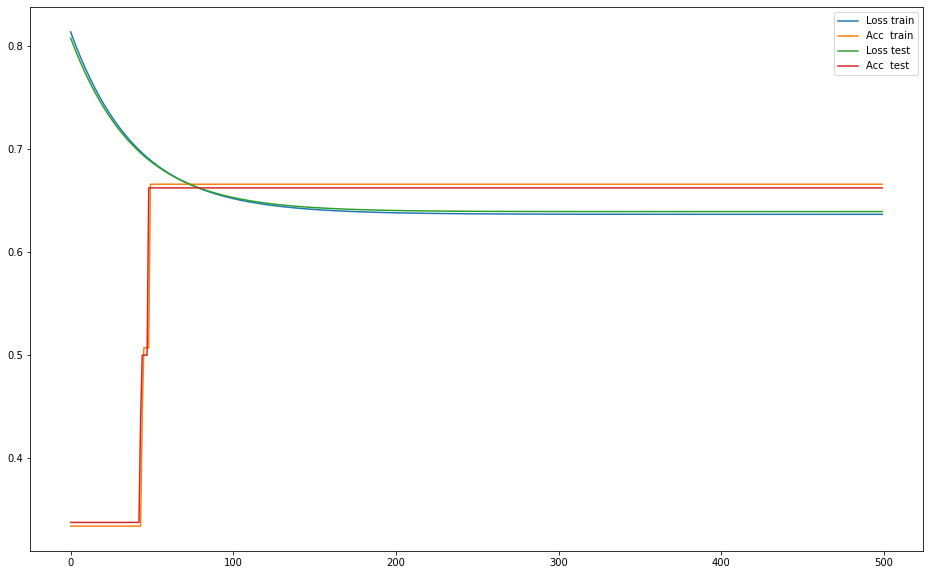

In [13]:
fig = plt.figure(figsize=(16,10))
plt.plot(ltr_curve, label="Loss train")
plt.plot(atr_curve, label="Acc  train")
plt.plot(lts_curve, label="Loss test")
plt.plot(ats_curve, label="Acc  test")
plt.legend()
plt.show()

In [14]:
coef = [p.cpu().detach().numpy() for p in model.parameters()]
print(coef)

[array([[0.8900648 , 0.7111705 , 0.27485806, ..., 0.15393485, 0.9812651 ,
        0.9482185 ],
       [0.1033314 , 0.3419702 , 0.09187113, ..., 0.90486985, 0.40766478,
        0.03949242]], dtype=float32), array([-0.6546471, -0.7187471], dtype=float32)]


In [15]:
print(coef[0].shape)
W = coef[0].reshape(2, n_channels, n_samples)
print(W.shape)

(2, 14028)
(2, 28, 501)


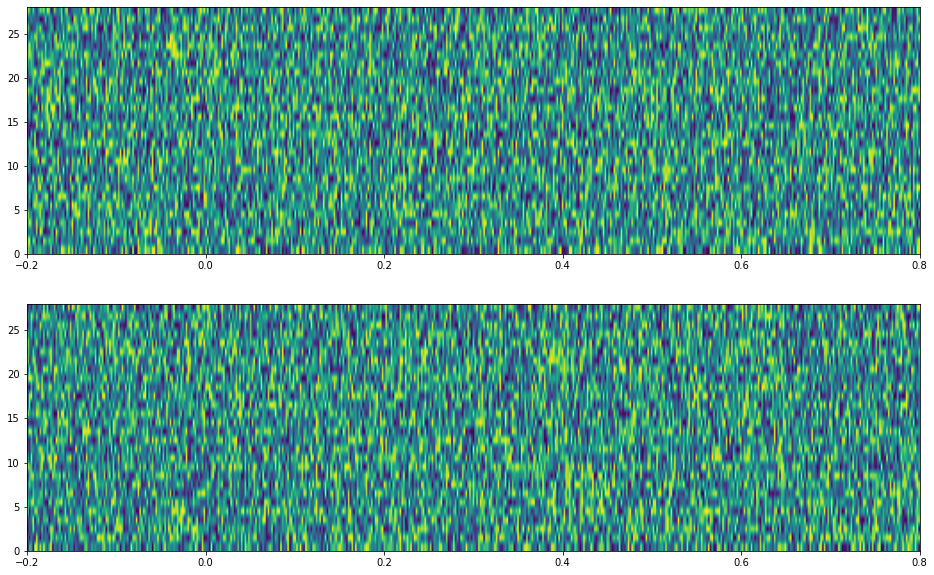

In [16]:
fig, axs = plt.subplots(2,1,figsize=(16,10))
axs[0].imshow(W[0,:,:], extent=[tmin, tmax,0,28], interpolation=None)
axs[0].set_aspect("auto")
axs[1].imshow(W[1,:,:], extent=[tmin, tmax,0,28], interpolation=None)
axs[1].set_aspect("auto")
plt.show()

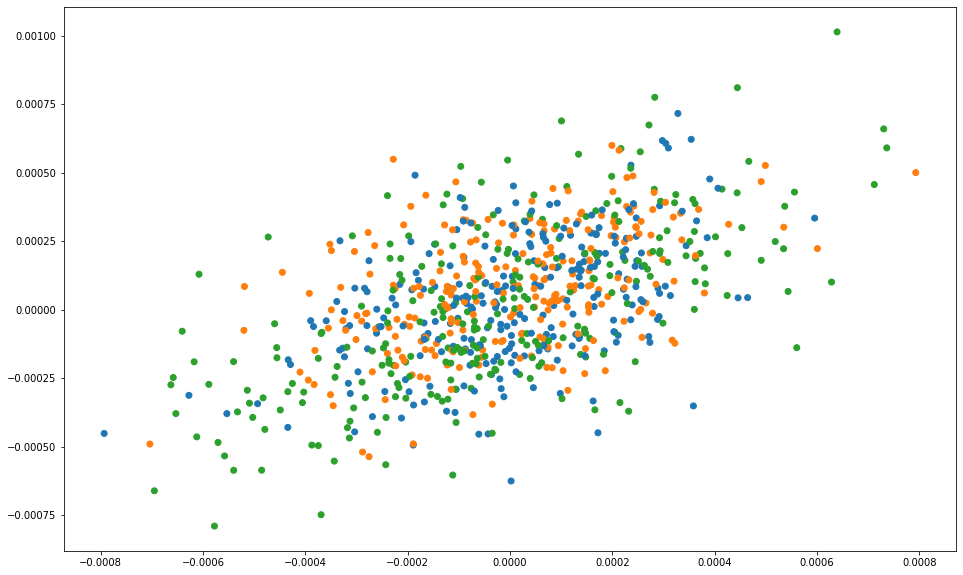

In [17]:
X_embedded = np.matmul(X, coef[0].transpose())
fig = plt.figure(figsize=(16,10))
cmap = plt.cm.get_cmap('tab10')
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cmap([a*2 + b for a,b in Y[:,:2]]), label=[a*2 + b for a,b in Y[:,:2]])
# plt.legend()

# Visualization

In [18]:
inputs = Variable(torch.tensor(X.astype(np.float32))).to(device)
labels = Variable(torch.tensor(Y.astype(np.float32))).to(device)

y_hat = model(inputs).round().cpu().detach().numpy()
print(y_hat.shape)

(797, 2)


In [19]:
Y.shape

(797, 2)

In [20]:
accuracy_score(y_hat, Y)

0.3299874529485571

In [21]:
from sklearn.model_selection import KFold

inputDim = X.shape[1]        # takes variable 'x' 
outputDim = Y.shape[1]       # takes variable 'y'
learningRate = 0.1 
epochs = 200 # Early stopping.
accuracy.to(device)


kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


In [22]:
def train_model(X_train, Y_train, X_test, Y_test):
    model = LogisticRegression(inputDim, outputDim)
    model.to(device)
    criterion = torch.nn.BCELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
    
    model.init(torch.nn.init.uniform_)
    ltr_curve, atr_curve = [], [] # Train and test loss and accuracy 
    lts_curve, ats_curve = [], []
    for epoch in range(epochs):
        # Train Set
        inputs = Variable(torch.tensor(X_train.astype(np.float32))).to(device)
        labels = Variable(torch.tensor(Y_train.astype(np.float32))).to(device)

        optimizer.zero_grad()
        y_hat = model(inputs)

        loss = criterion(y_hat, labels)
        train_loss = loss.item()
        ltr_curve.append(train_loss)

#         train_acc = accuracy(y_hat, labels.int())
#         atr_curve.append(train_acc.cpu().detach().numpy())

        # Optimization
        loss.backward()
        optimizer.step()

        # Test set    
        y_hat = model(Variable(torch.tensor(X_test.astype(np.float32))).to(device))
        test_lbls = Variable(torch.tensor(Y_test.astype(np.float32))).to(device)
        test_loss = criterion(y_hat, test_lbls)
        test_loss = test_loss.item()
        lts_curve.append(test_loss)
        test_acc = accuracy(y_hat, test_lbls.int())
        ats_curve.append(test_acc.cpu().detach().numpy())

#         print(f"epoch {epoch}, loss {loss.item()}, Acctst: {ats_curve[-1]}")

    return ats_curve[-1][()]# list of zero-dimensional np arrays to list

```python
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
```

loss 0.637499988079071
loss 0.684374988079071
loss 0.6698113083839417
loss 0.6855345964431763
loss 0.6477987170219421


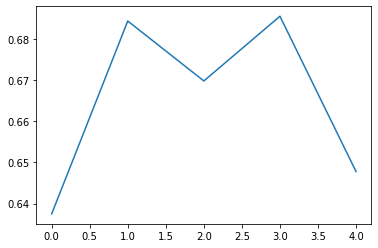

In [23]:
cvl = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_train, Y_test = Y[train_index,:], Y[test_index,:]
#     print("TRAIN:", X_train.shape, "TEST:", X_test.shape)
#     print("TRAIN:", Y_train.shape, "TEST:", Y_test.shape)
    cvl.append(train_model(X_train, Y_train, X_test, Y_test))
    print('loss {}'.format(cvl[-1]))
plt.plot(cvl)

In [24]:
!pip install seaborn

In [25]:
import seaborn as sns

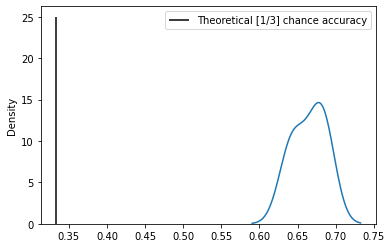

In [26]:
cross_validation_scores = cvl
sns.kdeplot(cvl)
plt.vlines([1/3], 0, 25, colors='k', linestyles='solid', label='Theoretical [1/3] chance accuracy')
plt.legend()


Training 0, loss: 0.6761006116867065

Training 1, loss: 0.6446540951728821

Training 2, loss: 0.6415094137191772

Training 3, loss: 0.6446540951728821

Training 4, loss: 0.6823899149894714

Training 5, loss: 0.6666666865348816

Training 6, loss: 0.6918238997459412

Training 7, loss: 0.6698113083839417

Training 8, loss: 0.6540880799293518

Training 9, loss: 0.6886792182922363


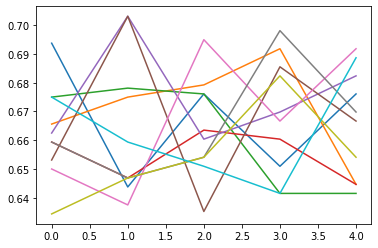

In [27]:
N_perm = 10
chance_cvl = []
for i in range(N_perm):
    print()
    cvl = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index,:], X[test_index,:]
        Y = np.random.permutation(Y)
        Y_train, Y_test = Y[train_index,:], Y[test_index,:]
    #     print("TRAIN:", X_train.shape, "TEST:", X_test.shape)
    #     print("TRAIN:", Y_train.shape, "TEST:", Y_test.shape)
        cvl.append(train_model(X_train, Y_train, X_test, Y_test))
    plt.plot(cvl)
    print(f"Training {i}, loss: {cvl[-1]}")
    chance_cvl.append(cvl)

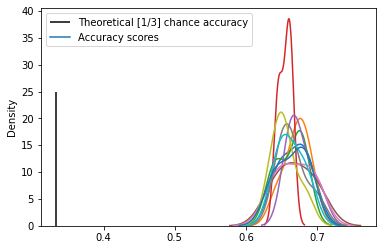

In [28]:
plt.vlines([1/3], 0, 25, colors='k', linestyles='solid', label='Theoretical [1/3] chance accuracy')
for i in chance_cvl:
    sns.kdeplot(i)
sns.kdeplot(cross_validation_scores, label="Accuracy scores")
plt.legend()

In [29]:
chance_scores = np.array(chance_cvl).reshape(-1)
chance_scores

array([0.69375  , 0.64375  , 0.6761006, 0.6509434, 0.6761006, 0.665625 ,
       0.675    , 0.6792453, 0.6918239, 0.6446541, 0.675    , 0.678125 ,
       0.6761006, 0.6415094, 0.6415094, 0.659375 , 0.646875 , 0.663522 ,
       0.6603774, 0.6446541, 0.6625   , 0.703125 , 0.6603774, 0.6698113,
       0.6823899, 0.653125 , 0.703125 , 0.6352201, 0.6855346, 0.6666667,
       0.65     , 0.6375   , 0.6949686, 0.6666667, 0.6918239, 0.659375 ,
       0.646875 , 0.6540881, 0.6981132, 0.6698113, 0.634375 , 0.646875 ,
       0.6540881, 0.6823899, 0.6540881, 0.675    , 0.659375 , 0.6509434,
       0.6415094, 0.6886792], dtype=float32)

In [30]:
cross_validation_scores = np.array(cross_validation_scores)
cross_validation_scores

array([0.6375   , 0.684375 , 0.6698113, 0.6855346, 0.6477987],
      dtype=float32)

In [31]:
conf_int = np.quantile(chance_scores, 0.95)
print(conf_int)

0.696698123216629


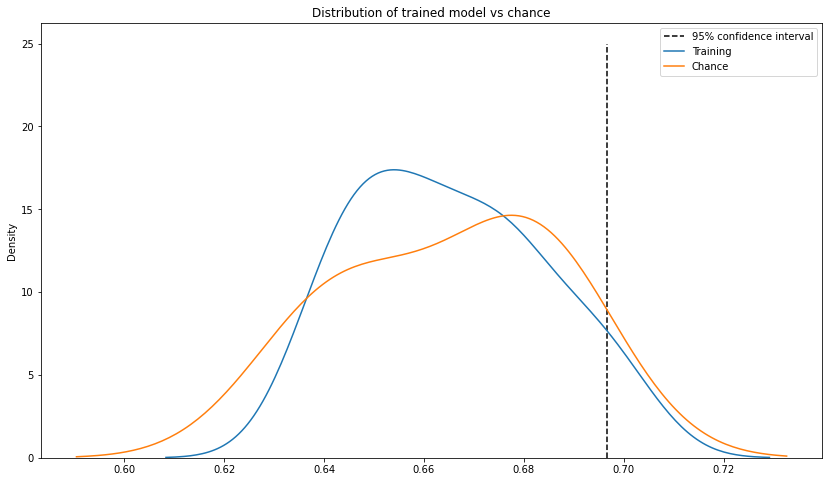

In [32]:
fig = plt.figure(figsize=(14,8))
plt.vlines([conf_int], 0, 25, colors='k', linestyles='dashed', label='95% confidence interval')
sns.kdeplot(chance_scores, label="Training")
sns.kdeplot(cross_validation_scores, label="Chance")
plt.title("Distribution of trained model vs chance")
plt.legend()

In [33]:
from scipy.stats import mannwhitneyu, ttest_ind
U, p = mannwhitneyu(chance_scores, cross_validation_scores)
print(U, p)

123.0 0.9649483715817309


In [34]:
t, p = ttest_ind(chance_scores, cross_validation_scores)
print(t, p)

0.02727802368826628 0.9783404388006249
